# 1. Displaced-diffusion model Calibration

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
import datetime as dt
from scipy.optimize import least_squares

In [2]:
rate_df = pd.read_csv('discount.csv')
call_df = pd.read_csv("goog_call.csv")
put_df = pd.read_csv("goog_put.csv")

In [3]:
today = dt.date(2013, 8, 30)
expiry = dt.date(2015, 1, 17)
T = (expiry-today).days/365.0
r = np.interp((expiry - today).days, rate_df['Day'], rate_df['Rate (%)'])/100

In [4]:
S = 846.9
F = S * np.exp(r*T)

In [5]:
# get the mid price of bid/offer as option price
call_df['mid'] = (call_df['best_bid'] + call_df['best_offer']) / 2
put_df['mid'] = (put_df['best_bid'] + put_df['best_offer']) / 2

In [6]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [7]:
# focus on the out of the money put and out of the money call
put_df_option = put_df[put_df['strike'] <= F]
call_df_option = call_df[call_df['strike'] >= F]

In [8]:
call_df_option['impliedvol'] = call_df_option.apply(lambda x: 
                                                    impliedCallVolatility(S, x['strike'],r,  x['mid'], T), axis=1)

put_df_option['impliedvol'] = put_df_option.apply(lambda x: 
                                                  impliedPutVolatility(S, x['strike'],r,  x['mid'], T), axis=1)


<ipython-input-8-d6c24067cec1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_df_option['impliedvol'] = call_df_option.apply(lambda x:
<ipython-input-8-d6c24067cec1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_df_option['impliedvol'] = put_df_option.apply(lambda x:


In [9]:
df2 = pd.concat([put_df_option, call_df_option])

In [10]:
df2

,date,expiry,strike,best_bid,best_offer,mid,impliedvol
0,20130830,20150117,320,0.90,2.00,1.450,0.393102
1,20130830,20150117,340,0.15,2.30,1.225,0.361520
2,20130830,20150117,350,0.80,2.45,1.625,0.365782
3,20130830,20150117,360,0.60,2.65,1.625,0.355104
4,20130830,20150117,370,0.65,2.85,1.750,0.348660
...,...,...,...,...,...,...,...
117,20130830,20150117,1330,5.70,9.00,7.350,0.240758
118,20130830,20150117,1340,5.30,8.60,6.950,0.240881
119,20130830,20150117,1350,5.70,8.20,6.950,0.243821
120,20130830,20150117,1360,5.50,7.80,6.650,0.244487


In [11]:
def Black76Call(F, K, sigma, r, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, r, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, r, beta, T):
    dd_option = Black76Call(F/beta, K+(1-beta)/beta*F, sigma*beta, r, T)
    return dd_option

def DD_Put(F, K, sigma, r, beta, T):
    dd_option = Black76Put(F/beta, K+(1-beta)/beta*F, sigma*beta,r, T)
    return dd_option

In [12]:
def volatility(S, F, K, r, T, sigma, beta):
    if K < F:
        price =  DD_Put(F, K, sigma, r, beta, T)
        vol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)
    else:
        price = DD_Call(F, K, sigma, r, beta, T)
        vol =  brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)
    return vol

In [13]:
def ddcalibration(x, S, F, strikes, vols, r,  T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - volatility(S, F, strikes[i], r,  T, x[0], x[1]))**2

    return err

### keep sigma constant, change beta to see how the curve is shaping

In [19]:
df2['beta0.2'] = df2.apply(lambda x: volatility(S, F, x['strike'], r, T, sigma, beta=0.2), axis =1 )
df2['beta0.6'] = df2.apply(lambda x: volatility(S, F, x['strike'], r, T, sigma, beta=0.6), axis =1 )
df2['beta0.8'] = df2.apply(lambda x: volatility(S, F, x['strike'], r, T, sigma, beta=0.8), axis =1 )

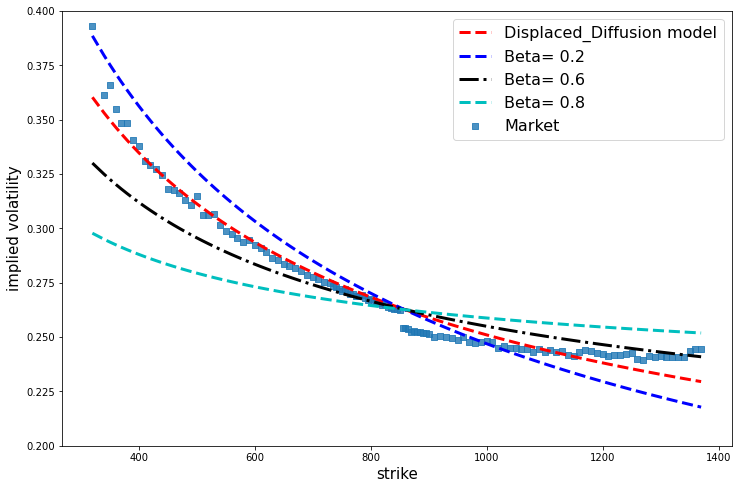

In [24]:
plt.figure(figsize = (12, 8))
plt.plot(df2['strike'], df2['dd_vol'], '--r', linewidth = 3, label = 'Displaced_Diffusion model')
plt.plot(df2['strike'], df2['beta0.2'], '--b', linewidth = 3, label = "Beta= 0.2")
plt.plot(df2['strike'], df2['beta0.6'], '-.k', linewidth = 3, label = "Beta= 0.6")
plt.plot(df2['strike'], df2['beta0.8'], '--c', linewidth = 3, label = "Beta= 0.8")
plt.scatter(df2['strike'],df2['impliedvol'],marker = 's', alpha = 0.8, label = 'Market')
plt.ylim(0.2, 0.4)
plt.xlabel('strike', fontsize = 15)
plt.ylabel('implied volatility', fontsize = 15)
plt.legend(fontsize = 16);

# 2. SABR Model calibration

In [26]:
beta = 0.8

In [25]:
df = pd.concat([put_df_option, call_df_option])

In [27]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [28]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [29]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'],
                                              df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

In [30]:
print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.991, beta = 0.8, rho = -0.285, nu = 0.352


In [31]:
df['sabrsigma'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, rho, nu), axis = 1)

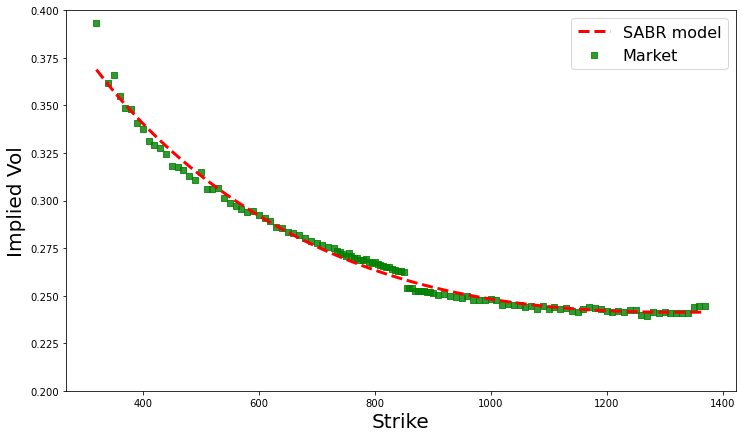

In [32]:
plt.figure(figsize = (12, 7))
plt.scatter(df['strike'],df['impliedvol'], alpha = 0.8, c = 'g' ,marker = 's', label = 'Market')
plt.plot(df['strike'], df['sabrsigma'], '--r', linewidth = 3, label = 'SABR model')
plt.ylabel('Implied Vol', fontsize = 20)
plt.xlabel('Strike', fontsize = 20)
plt.ylim(0.2, 0.4)
plt.legend(fontsize = 16);

### 1) Keep, alpha, beta, nu constant, changing rho to check how the curve is performing

In [34]:
alpha = 0.991
beta = 0.8
nu = 0.352

In [36]:
df['rho-0.5'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, -0.5, nu), axis = 1)
df['rho0'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta,  0, nu), axis = 1)
df['rho0.5'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, 0.5, nu), axis = 1)

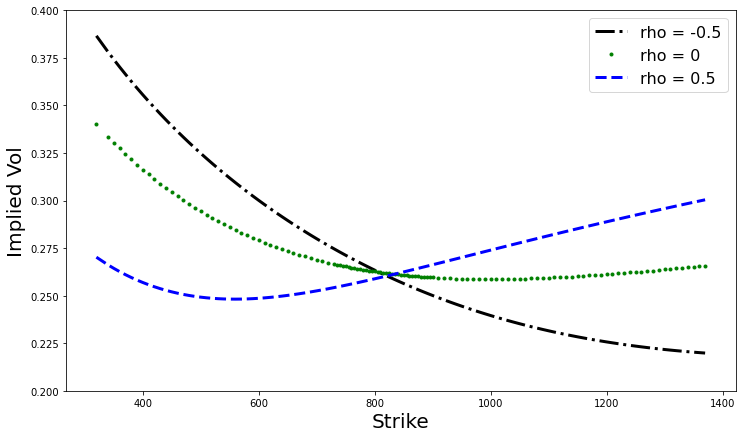

In [39]:
plt.figure(figsize = (12, 7))
plt.plot(df['strike'], df['rho-0.5'], '-.k', linewidth = 3, label = 'rho = -0.5')
plt.plot(df['strike'], df['rho0'], '.g', linewidth = 3, label = 'rho = 0')
plt.plot(df['strike'], df['rho0.5'], '--b', linewidth = 3, label = 'rho = 0.5')
plt.ylabel('Implied Vol', fontsize = 20)
plt.xlabel('Strike', fontsize = 20)
plt.ylim(0.2, 0.4)
plt.legend(fontsize = 16);

### 2) keep alpha, beta, rho constant, changing nu to see how the curve is shaping

In [40]:
alpha = 0.991
beta = 0.8
rho = -0.285

In [41]:
df['nu0.1'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, rho, 0.1), axis = 1)
df['nu0.3'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, rho, 0.3), axis = 1)
df['nu0.5'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, rho, 0.5), axis = 1)

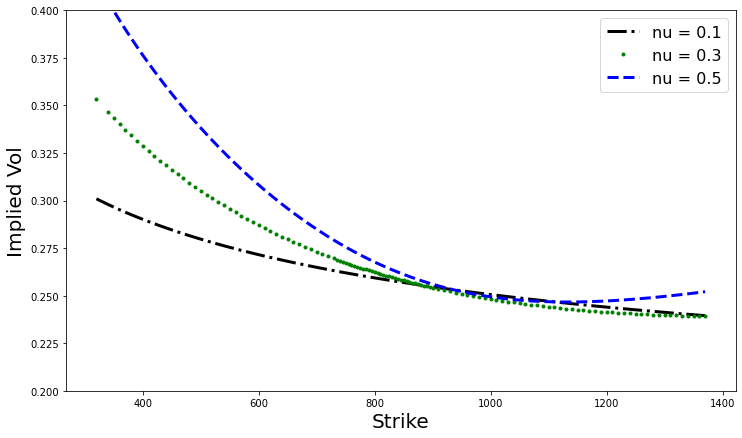

In [42]:
plt.figure(figsize = (12, 7))
plt.plot(df['strike'], df['nu0.1'], '-.k', linewidth = 3, label = 'nu = 0.1')
plt.plot(df['strike'], df['nu0.3'], '.g', linewidth = 3, label = 'nu = 0.3')
plt.plot(df['strike'], df['nu0.5'], '--b', linewidth = 3, label = 'nu = 0.5')
plt.ylabel('Implied Vol', fontsize = 20)
plt.xlabel('Strike', fontsize = 20)
plt.ylim(0.2, 0.4)
plt.legend(fontsize = 16);